In [149]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
def load_dataframe(path):
    classes = os.listdir(path)
    df = pd.DataFrame()
    
    for cls in classes:
        cls_path = os.path.join(path, cls)
        
        if not os.path.isdir(cls_path):
            continue
            
        for file in os.listdir(cls_path):
            image_path = os.path.join(path, cls, file)
            
            if os.path.isfile(image_path):
                image = Image.open(image_path)
                image = np.asarray(image, dtype=np.double)
                image_norm = np.linalg.norm(image)
                if image_norm == 0:
                    continue
                image /= image_norm
                df = df.append(pd.Series({'emotion': cls, 'image': image}), ignore_index=True)
    
    return df

In [98]:
df_train = load_dataframe('data/train')
df_test = load_dataframe('data/test')

In [4]:
df_train.shape

(28698, 2)

In [5]:
df_train['emotion'].value_counts()

happy       7214
neutral     4964
sad         4829
fear        4097
angry       3988
surprise    3170
disgust      436
Name: emotion, dtype: int64

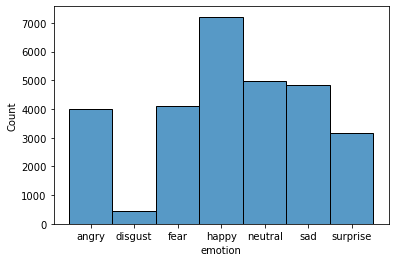

In [6]:
sns.histplot(df_train['emotion']);

In [7]:
df_train.head()

,emotion,image
0,angry,"[[0.008852438274353128, 0.005665560495586001, ..."
1,angry,"[[0.005020191736857478, 0.004154641437399292, ..."
2,angry,"[[0.02534378514188006, 0.02256414419083515, 0...."
3,angry,"[[0.026124269527077703, 0.0266195163427569, 0...."
4,angry,"[[0.006619074423807762, 0.006802937602246866, ..."


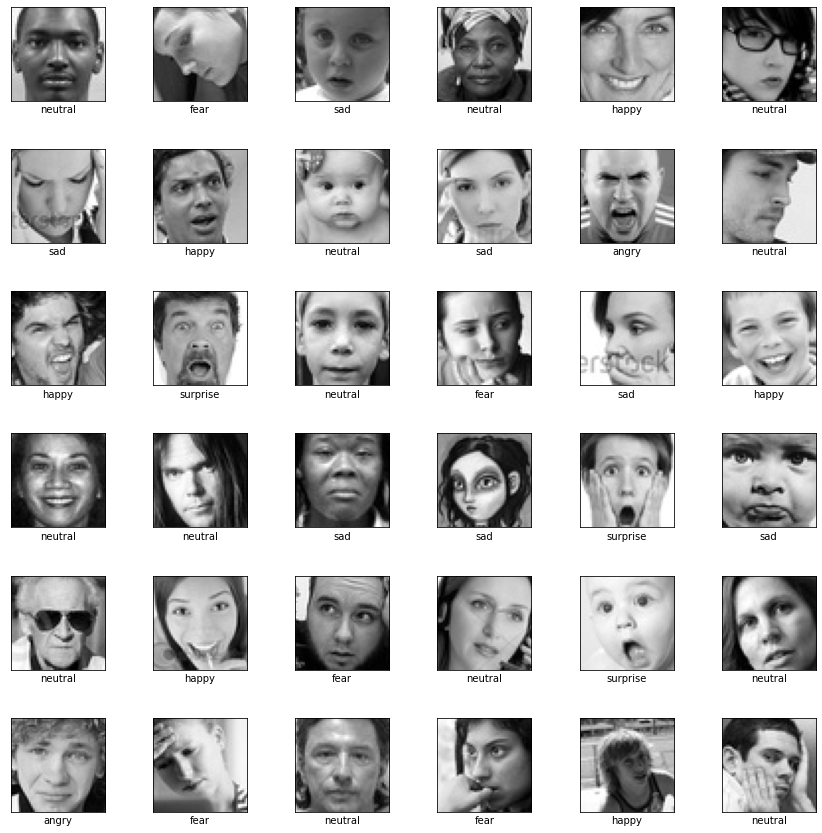

In [8]:
def plot_as_images(rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2,rows*2))
    fig.tight_layout()
    
    for i in range(rows):
        for j in range(cols):
            index = np.random.choice(np.arange(len(df_train)))
            axes[i,j].imshow(df_train.image[index], cmap="gray")
            axes[i,j].set_xlabel(df_train.emotion[index])
            axes[i,j].get_yaxis().set_visible(False)
            axes[i,j].set_xticks([])

plot_as_images(6, 6)

In [9]:
nclasses = df_train.emotion.nunique()
img_size = df_train.image[0].shape[0]

In [10]:
emotions = df_train.emotion.unique()
emotions_map = {emotion: i for i, emotion in enumerate(emotions)}
emotions_map

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [11]:
def normalize(X):
    #return (X - np.expand_dims(X.mean(axis=1), 1)) / np.expand_dims(X.std(axis=1), 1)
    return X

def preprocess_dataframe(df):    
    X = np.stack(df.image.apply(lambda img: img.reshape(img_size * img_size, order='F')).values)
    y = df.emotion.apply(lambda emo: emotions_map[emo])
    
    return normalize(X), y

In [127]:
X_train, y_train = preprocess_dataframe(df_train)
X_train.shape, y_train.shape

((37219, 2304), (37219,))

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [14]:
clf = LogisticRegression(fit_intercept=True, multi_class='auto', penalty='l2', solver='saga').fit(X_train, y_train)

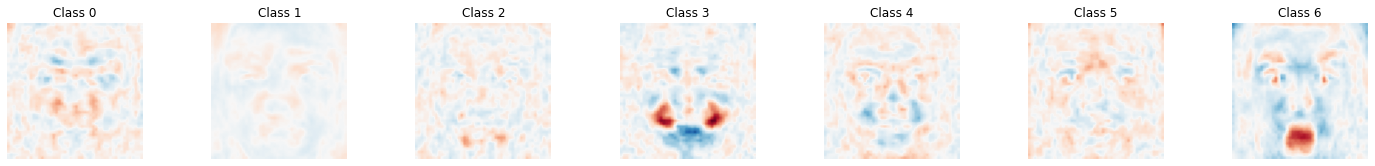

In [15]:
scale = np.max(np.abs(clf.coef_))

p = plt.figure(figsize=(25, 2.5));

for i in range(nclasses):
    p = plt.subplot(1, nclasses, i + 1)
    p = plt.imshow(clf.coef_[i].reshape(img_size, img_size, order='F'),
                  cmap=plt.cm.RdBu, vmin=-scale, vmax=scale);
    p = plt.axis('off')
    p = plt.title('Class %i' % i);

In [16]:
from sklearn.metrics import accuracy_score
X_test, y_test = preprocess_dataframe(df_test)

In [17]:
from sklearn.model_selection import GridSearchCV

def get_best_params(X, y):
    params = {'penalty': ['l1', 'l2', 'elasticnet'], 'tol': np.linspace(1e-14, 0.1, 5), 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']}
    clf = GridSearchCV(LogisticRegression(), params)
    clf.fit(X, y)
    return clf.best_params_

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=250, svd_solver='full').fit(X_train)

In [19]:
pca.components_.shape

(250, 2304)

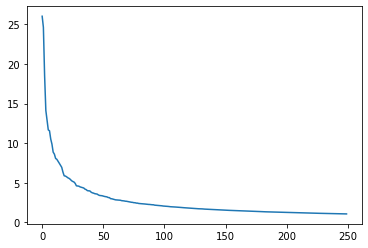

In [20]:
plt.plot(pca.singular_values_)

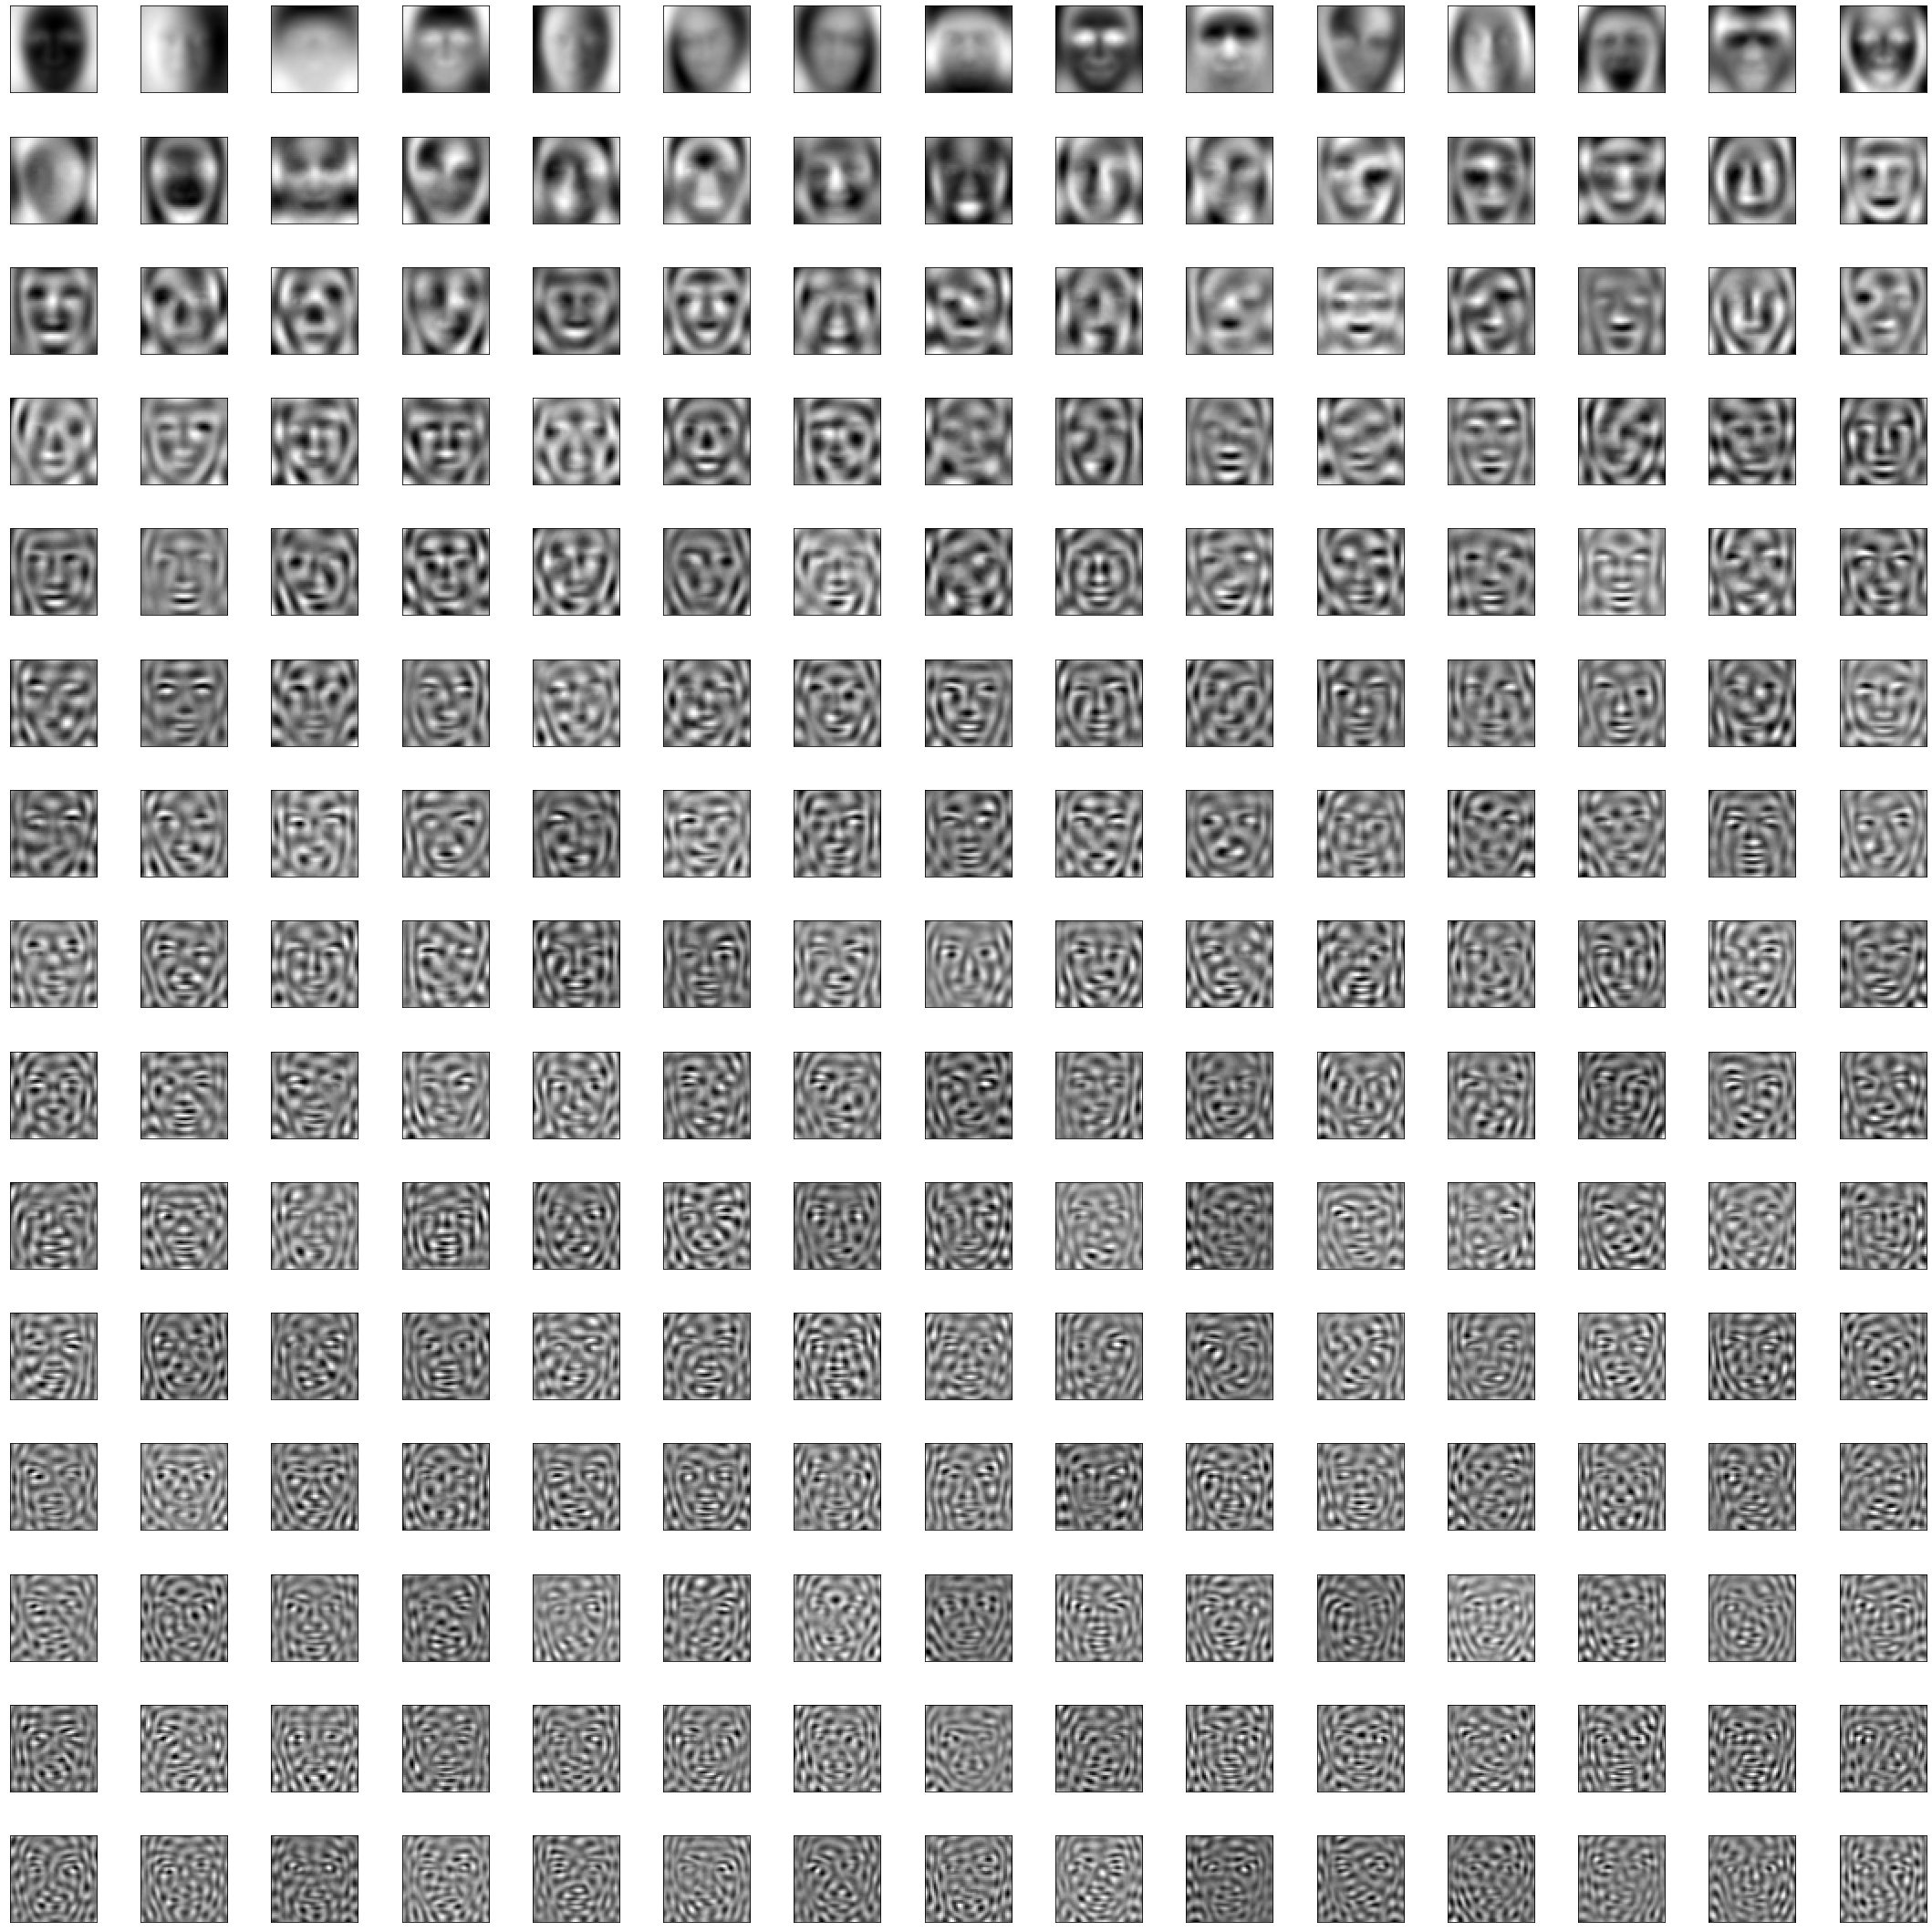

In [21]:
rows = cols = int(np.sqrt(pca.n_components_))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
fig.tight_layout()

for i in range(rows):
    for j in range(cols):
        axes[i,j].imshow(pca.components_[i * cols + j].reshape(img_size, img_size, order='F'), cmap='gray')
        axes[i,j].get_yaxis().set_visible(False)
        axes[i,j].set_xticks([])
        

In [22]:
def plot_rank_acc(clf, a, b, step=20):
    ranks = np.arange(a, b, step)
    scores = []
    
    for rank in ranks:
        print(f"rank={rank}")
        pca = PCA(n_components=rank, svd_solver='randomized').fit(X_train)
        X_train_new = pca.transform(X_train)
        clf = clf.fit(X_train_new, y_train)
        scores.append(accuracy_score(y_test, clf.predict(pca.transform(normalize(X_test)))))
        
    fig = sns.lineplot(x=ranks, y=scores)
    plt.xlabel("Rank")
    plt.ylabel("Scores")
    plt.show(fig)
    
    return ranks, scores
    

#ranks, rank_scores = plot_rank_acc(SVC(kernel='rbf'), 300, 500, 50)

In [23]:
#n_components = ranks[np.argmax(rank_scores)]
n_components = 250
n_components

250

In [24]:
#np.max(rank_scores)

In [25]:
def test_SVM_kernels():
    for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
        print(kernel)
        pca = PCA(n_components=n_components, svd_solver='full').fit(X_train)
        X_train_new = pca.transform(X_train)
        clf = SVC(kernel=kernel).fit(X_train_new, y_train)
        print(accuracy_score(y_test, clf.predict(pca.transform(normalize(X_test)))))

In [128]:
pca = PCA(n_components=n_components, svd_solver='full').fit(X_train)
X_train_new = pca.transform(X_train)
X_test_new = pca.transform(X_test)

In [129]:
clf = SVC(kernel='rbf').fit(X_train_new, y_train)
y_pred = clf.predict(X_test_new)
accuracy_score(y_test, y_pred)

0.4086665737773443

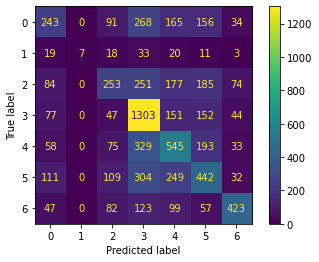

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

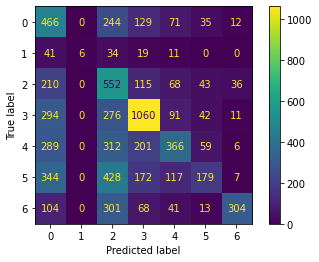

In [145]:
cm2 = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm2).plot()

In [115]:
def accuracy_for_classes(cm):
    for i in range(cm.shape[0]):
        print(cm[i][i] / np.sum(cm[i]) * 100)

In [144]:
def accuracy(cm):
    s = 0
    for i in range(cm.shape[0]):
        s += cm[i][i]
    return s / np.sum(cm)

accuracy(cm), accuracy(cm2)

(0.4480980911244252, 0.426779991639961)

In [146]:
accuracy_for_classes(cm)

25.391849529780565
6.306306306306306
24.70703125
73.44983089064262
44.20113544201135
35.44506816359262
50.90252707581227


In [147]:
accuracy_for_classes(cm2)

48.69383490073145
5.405405405405405
53.90625
59.75197294250282
29.683698296836987
14.354450681635928
36.58243080625752


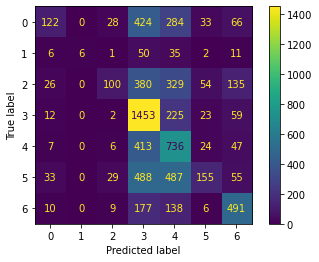

In [28]:
import pickle
def save_model():
    pickl = {'pca': pca, 'clf': clf}
    pickle.dump(pickl, open('models' + ".p", "wb"))

In [29]:
'''{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}'''

"{'angry': 0,\n 'disgust': 1,\n 'fear': 2,\n 'happy': 3,\n 'neutral': 4,\n 'sad': 5,\n 'surprise': 6}"

In [86]:
def get_images_tensor(df):
    return np.apply_along_axis(lambda row: row.tolist(), 0, df.image.values)
    
def flip_images(df):
    return np.flip(get_images_tensor(df), axis=2)

In [99]:
df_train.shape

(28698, 2)

In [90]:
def append_flipped_images(df, column):
    imgs = flip_images(df[df['emotion'] == column])

    for img in imgs:
        df = df.append(pd.Series({'emotion': column, 'image': img}), ignore_index=True)
    
    return df

In [125]:
df_train = append_flipped_images(df_train, 'angry')
df_train = append_flipped_images(df_train, 'disgust')
df_train = append_flipped_images(df_train, 'fear')

In [143]:
df_train.shape

(28698, 2)

In [142]:
#df_train.drop(range(28698, 37219), inplace=True)